# Detecting Handling Bleed Valve Failure using Machine Learning

#### Developer: Oishi Deb

In [211]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#from sympy import *
#from bokeh.plotting import figure
#from bokeh.io import output_file, show
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters
from tsfresh.feature_extraction.settings import TimeBasedFCParameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import pickle

# If you are using old version of Jupyter, then you need this line for the plots to be visible
%matplotlib inline 

# 1. Data Pre-processing

Here we import real Trent XWB engine development test data from EMS, which comes in a csv tabular format. 

The raw data is generated by using a TCL (Tool Command Language) script to:
- Extract the parameters of interest (pressures, temperatures, shaft speeds and HBV commands)
- Extract a time slice lasting 0.7 seconds, that starts with a command to transition a bleed valve from the open to closed position. Each row in the file represents a 24ms sample.

For the purposes of this Jupyter project, 8 samples of data (that is, data from 8 separate engine runs), were combined in a single csv file.

Four of the files contain bleed valve transition commands, and four do not.

We read the input files into Python as a Pandas data frame, and display the first five values to give us confidence that the data is valid.

In [212]:
path_to_file = 'Combined_No_HBV_Failure&HBV_Failure_12.csv'
ems_df = pd.read_csv(path_to_file , index_col='Time', parse_dates=True)
ems_df.head()

,id,N1,N2,N3,P0,P20,P30,T20,T25,T30,TGT,VSVAPos,FuelFlow,HP1BVCmd,HP2BVCmd,HP3BVCmd,IP1BVCmd,IP3BVCmd,IP4BVCmd
Time,,,,,,,,,,,,,,,,,,,
00:18:33.6240,0,13.963,40.875,53.854,14.625,14.626,53.203,248.65,263.058,357.683,633.149048,1.937,1911.938,1,1,1,1,1,1
00:18:33.6480,0,14.006,41.032,53.890,14.625,14.626,53.281,248.65,263.058,358.118,633.149048,1.939,1911.938,1,1,0,1,1,1
00:18:33.6720,0,14.006,41.032,53.938,14.625,14.625,53.328,248.65,263.411,358.118,633.149048,1.941,1911.938,1,1,0,1,1,1
00:18:33.6959,0,14.055,41.200,53.987,14.625,14.625,53.422,248.65,263.411,358.648,633.149048,1.942,1911.938,1,1,0,1,1,1
00:18:33.7200,0,14.055,41.200,54.025,14.625,14.625,53.594,248.65,263.411,358.648,636.090942,1.944,1914.224,1,1,0,1,1,1


Next, we read in a csv file that has been created, either manually (for small files) or automatically using Python (for larger files). This file represents the labelled data, which will later be split into training and test data.

0 = No HBV failure

1 = HBV failure

We define the labels as a Pandas series, since this is the format required in later Feature Selection functions. Any missing values are removed, using standard Pandas methods. Finally, any required formatting is applied.

In [213]:
Labels = pd.read_csv("Labels_12.csv")
Labels = Labels.iloc[:, 1].values
Labels

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], dtype=int64)

In [214]:
# Create a Pandas series for the labels
data = np.array(['0','0', '0','0', '0','0','1','1', '1','1', '1','1'])
#data = np.array(['0','0', '0','0', '1','1', '1','1'])
LabelsSeries = pd.Series(data)
LabelsSeries

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     1
9     1
10    1
11    1
dtype: object

In [215]:
#ems_df = ems_df.drop([0])
ems_df = ems_df.dropna()
ems_df.head()

,id,N1,N2,N3,P0,P20,P30,T20,T25,T30,TGT,VSVAPos,FuelFlow,HP1BVCmd,HP2BVCmd,HP3BVCmd,IP1BVCmd,IP3BVCmd,IP4BVCmd
Time,,,,,,,,,,,,,,,,,,,
00:18:33.6240,0,13.963,40.875,53.854,14.625,14.626,53.203,248.65,263.058,357.683,633.149048,1.937,1911.938,1,1,1,1,1,1
00:18:33.6480,0,14.006,41.032,53.890,14.625,14.626,53.281,248.65,263.058,358.118,633.149048,1.939,1911.938,1,1,0,1,1,1
00:18:33.6720,0,14.006,41.032,53.938,14.625,14.625,53.328,248.65,263.411,358.118,633.149048,1.941,1911.938,1,1,0,1,1,1
00:18:33.6959,0,14.055,41.200,53.987,14.625,14.625,53.422,248.65,263.411,358.648,633.149048,1.942,1911.938,1,1,0,1,1,1
00:18:33.7200,0,14.055,41.200,54.025,14.625,14.625,53.594,248.65,263.411,358.648,636.090942,1.944,1914.224,1,1,0,1,1,1


In [216]:
#ems_df['Time'] = pd.to_datetime(ems_df['Time'], format=' %H:%M:%S.%f')
#ems_df.dtypes

In [217]:
#ems_df.head()

# 2. Feature Engineering

### 2.1 Feature Extraction using TSFRESH

Now that our data is in the required format, we use "Feature Calculation" (FC) methods from the TSFRESH package, to extract features from our input data, specifically P30.

TSFRESH has mechanisms to calculate missing values using 'Impute' function.

Different Interpolation techniques are used to estimatte the missing values. One of the most common interpolation techniques is "Mean Imputation", where it replaces the missing value with the mean of the entire feature column.

<TODO: Explain what the "impute" parameter does>

We assign the output to a object X and print the list of all 794 extracted feature names.

In [218]:
extraction_settings = ComprehensiveFCParameters()

In [219]:
X = extract_features(ems_df, 
                     column_id='id', column_value = 'P30',  #column_sort = 'Time',
                     default_fc_parameters=extraction_settings,
                     impute_function= impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  4.70it/s]
 'P30__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"rvalue"'
 'P30__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"'
 'P30__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"stderr"'
 'P30__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"'
 'P30__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"rvalue"'
 'P30__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"slope"'
 'P30__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"stderr"'
 'P30__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"'
 'P30__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"rvalue"'
 'P30__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"slope"'
 'P30__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"stderr"'
 'P30__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"intercept"'
 'P30__agg_linear_trend__f_agg_"var"__chunk_len_50__attr_"rvalue"'

Now that the features have been extracted, we show the table of values for each data sample.

In [220]:
#X.transpose()

In [221]:
# Save all the Extracted feature values to a CSV file
X.to_csv("All_Tsfresh_Features.csv")

### 2.2 Feature Selection using TSFRESH

In [222]:
## Need to do: Explain how FDR - False Discovery Rate is calculated 
impute(X)
features_filtered = select_features(X, LabelsSeries, fdr_level = 47) # if fdr_level value is less than 47 it outputs no features
features_filtered

variable,P30__first_location_of_maximum,P30__variance_larger_than_standard_deviation,P30__index_mass_quantile__q_0.1,P30__index_mass_quantile__q_0.3,P30__index_mass_quantile__q_0.4,P30__index_mass_quantile__q_0.6,P30__index_mass_quantile__q_0.2,P30__index_mass_quantile__q_0.8,P30__index_mass_quantile__q_0.9,P30__length,...,P30__ar_coefficient__k_10__coeff_4,P30__energy_ratio_by_chunks__num_segments_10__segment_focus_1,"P30__change_quantiles__f_agg_""mean""__isabs_True__qh_0.2__ql_0.0",P30__energy_ratio_by_chunks__num_segments_10__segment_focus_2,"P30__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20","P30__fft_coefficient__coeff_8__attr_""angle""","P30__change_quantiles__f_agg_""var""__isabs_True__qh_0.2__ql_0.0",P30__last_location_of_maximum,P30__number_cwt_peaks__n_5,P30__has_duplicate
id,,,,,,,,,,,,,,,,,,,,,
0,0.966667,1.0,0.133333,0.333333,0.433333,0.633333,0.233333,0.833333,0.933333,30.0,...,0.293634,0.094870,0.097750,0.095238,149.390996,142.000180,0.002123,1.000000,2.0,1.0
1,0.966667,1.0,0.133333,0.333333,0.433333,0.633333,0.233333,0.833333,0.933333,30.0,...,-0.598059,0.094463,0.071800,0.095130,153.108931,128.074064,0.000442,1.000000,3.0,0.0
2,0.966667,1.0,0.133333,0.333333,0.433333,0.633333,0.233333,0.833333,0.933333,30.0,...,-0.748200,0.094420,0.050000,0.095285,153.158937,127.882161,0.001502,1.000000,3.0,1.0
3,0.966667,1.0,0.133333,0.333333,0.433333,0.633333,0.233333,0.833333,0.933333,30.0,...,-0.053085,0.094316,0.125250,0.094999,153.495455,154.944707,0.005724,1.000000,2.0,1.0
4,0.966667,1.0,0.133333,0.333333,0.433333,0.633333,0.233333,0.833333,0.933333,30.0,...,-0.330596,0.093205,0.065600,0.093967,150.053082,140.176723,0.003567,1.000000,2.0,1.0
5,0.933333,1.0,0.133333,0.333333,0.433333,0.633333,0.233333,0.833333,0.933333,30.0,...,-0.566648,0.092946,0.050000,0.093862,151.630508,141.642954,0.001124,0.966667,2.0,1.0
6,0.967742,0.0,0.129032,0.322581,0.419355,0.612903,0.225806,0.806452,0.903226,31.0,...,0.097667,0.094318,0.086167,0.094835,149.708298,122.152871,0.006060,1.000000,3.0,1.0
7,0.967742,0.0,0.129032,0.322581,0.419355,0.612903,0.225806,0.806452,0.903226,31.0,...,0.053304,0.094300,0.062333,0.095085,153.126456,130.708361,0.001708,1.000000,2.0,1.0
8,0.967742,0.0,0.129032,0.322581,0.419355,0.612903,0.225806,0.806452,0.903226,31.0,...,-0.801837,0.094159,0.088667,0.094960,153.051984,136.295895,0.000868,1.000000,2.0,0.0


In [223]:
# Save all the Extracted feature values to a CSV file
features_filtered.to_csv("Filtered_Features.csv")

In [224]:
features_filtered_df = features_filtered
type (features_filtered_df)

pandas.core.frame.DataFrame

In [225]:
#features_filtered.transpose()

##### TSFRESH MinimalFCParameters function only selects 8 extracted features

In [226]:
# MinimalFCParameters
X_2 = extract_features(ems_df, column_id='id', column_value = 'P30', default_fc_parameters=MinimalFCParameters(),
                           impute_function=impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  6.20it/s]


In [227]:
X_2.head()

variable,P30__length,P30__maximum,P30__mean,P30__median,P30__minimum,P30__standard_deviation,P30__sum_values,P30__variance
id,,,,,,,,
0,30.0,56.797,54.967233,55.1330,53.203,1.247803,1649.017,1.557011
1,30.0,57.859,56.286033,56.8675,54.422,1.238520,1688.581,1.533932
2,30.0,57.953,56.309367,56.8440,54.500,1.236781,1689.281,1.529627
3,30.0,58.172,56.415667,56.8440,54.578,1.237064,1692.470,1.530328
4,30.0,57.453,55.412067,55.9455,53.297,1.501090,1662.362,2.253272


In [228]:
impute(X_2)
features_filtered_2 = select_features(X_2, LabelsSeries, fdr_level = 1)
features_filtered_2

variable,P30__length,P30__median,P30__maximum,P30__mean,P30__minimum,P30__standard_deviation,P30__variance,P30__sum_values
id,,,,,,,,
0,30.0,55.1330,56.797,54.967233,53.203,1.247803,1.557011,1649.017
1,30.0,56.8675,57.859,56.286033,54.422,1.238520,1.533932,1688.581
2,30.0,56.8440,57.953,56.309367,54.500,1.236781,1.529627,1689.281
3,30.0,56.8440,58.172,56.415667,54.578,1.237064,1.530328,1692.470
4,30.0,55.9455,57.453,55.412067,53.297,1.501090,2.253272,1662.362
5,30.0,56.5000,58.156,56.033400,53.813,1.560064,2.433800,1681.002
6,31.0,52.2030,53.203,52.215258,51.203,0.617340,0.381109,1618.673
7,31.0,53.3750,54.422,53.386645,52.391,0.603022,0.363636,1654.986
8,31.0,53.4060,54.500,53.405323,52.281,0.661964,0.438197,1655.565


In [229]:
#features_filtered_df_2 = features_filtered_2
#type (features_filtered_df_2)

In [230]:
#X_filtered = extract_relevant_features (X, LabelsSeries, column_id = 'id', 
#                                      default_fc_parameters=extraction_settings)
#X = pd.DataFrame(index=Labels.index)

IMPORTANT Note: The .values method of the pandas DataFrame yields the corresponding NumPy representation.

In [231]:
features_filtered = features_filtered.iloc[:, [1, 2]].values

#features_filtered = features_filtered.iloc[:].values
features_filtered

array([[1.        , 0.13333333],
       [1.        , 0.13333333],
       [1.        , 0.13333333],
       [1.        , 0.13333333],
       [1.        , 0.13333333],
       [1.        , 0.13333333],
       [0.        , 0.12903226],
       [0.        , 0.12903226],
       [0.        , 0.12903226],
       [0.        , 0.12903226],
       [0.        , 0.12903226],
       [0.        , 0.12903226]])

In [232]:
features_filtered_2 = features_filtered_2.iloc[:, [3, 6]].values # Mean and Variance
features_filtered_2

array([[54.96723333,  1.55701138],
       [56.28603333,  1.53393223],
       [56.30936667,  1.5296267 ],
       [56.41566667,  1.53032756],
       [55.41206667,  2.2532722 ],
       [56.0334    ,  2.43379977],
       [52.21525806,  0.38110851],
       [53.38664516,  0.36363558],
       [53.40532258,  0.43819693],
       [53.52370968,  0.40886982],
       [52.48796774,  0.24438784],
       [52.9773871 ,  0.21800998]])

In [233]:

#y = ems_df.iloc[:, 4].values

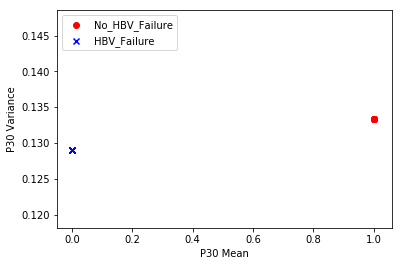

In [272]:
# plot data 
#  scatter plot takes the following inputs x axis value, y axis value
plt.scatter(features_filtered[:6, 0], features_filtered[:6, 1],  
            color='red', marker='o', label='No_HBV_Failure')
plt.scatter(features_filtered[6:12, 0], features_filtered[6:12, 1],
            color='blue', marker='x', label='HBV_Failure')

plt.xlabel('P30 Mean')
plt.ylabel('P30 Variance')
plt.legend(loc='upper left')

# plt.savefig('images/02_06.png', dpi=300)
plt.show()

### Feature Importance

In [235]:
features_filtered_df.columns[:]

Index(['P30__first_location_of_maximum',
       'P30__variance_larger_than_standard_deviation',
       'P30__index_mass_quantile__q_0.1', 'P30__index_mass_quantile__q_0.3',
       'P30__index_mass_quantile__q_0.4', 'P30__index_mass_quantile__q_0.6',
       'P30__index_mass_quantile__q_0.2', 'P30__index_mass_quantile__q_0.8',
       'P30__index_mass_quantile__q_0.9', 'P30__length',
       ...
       'P30__ar_coefficient__k_10__coeff_4',
       'P30__energy_ratio_by_chunks__num_segments_10__segment_focus_1',
       'P30__change_quantiles__f_agg_"mean"__isabs_True__qh_0.2__ql_0.0',
       'P30__energy_ratio_by_chunks__num_segments_10__segment_focus_2',
       'P30__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_3__w_20',
       'P30__fft_coefficient__coeff_8__attr_"angle"',
       'P30__change_quantiles__f_agg_"var"__isabs_True__qh_0.2__ql_0.0',
       'P30__last_location_of_maximum', 'P30__number_cwt_peaks__n_5',
       'P30__has_duplicate'],
      dtype='object', name='variable', length

In [236]:
#features_filtered_df_2.columns[:]

# 3. Machine Learning Model Building 

Note from Python Machine Learning book Chapter 4: "Instead of discarding the allocated test data after model training and evaluation, it is a common practice to retrain a classifier on the entire dataset as it can improve the predictive performance of the model."

In [237]:
# random_state is used so that the data is reproducible, as train_test_split shuffles the data
# stratification makes sure that the test data contains the same proportion of class labels as the input dataset.

X_train, X_test, y_train, y_test = train_test_split(features_filtered, Labels, random_state=1, stratify = Labels)

In [238]:
features_filtered.shape

(12, 2)

In [239]:
X_train.shape

(9, 2)

In [240]:
X_test.shape

(3, 2)

In [241]:
y_train.shape

(9,)

In [242]:
y_test.shape

(3,)

### PCA

In [243]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [244]:
import numpy as np
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' % eigen_vals)


Eigenvalues 
[ 2.25000000e+00 -2.22044605e-16]


In [245]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
var_exp

[1.0, -9.868649107779169e-17]

In [246]:
cum_var_exp = np.cumsum(var_exp)
cum_var_exp

array([1., 1.])

## Feature transformation

In [248]:
# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i])
               for i in range(len(eigen_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [249]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis],
               eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


In [250]:
X_train_std[0].dot(w)

array([1.26491106e+00, 4.99600361e-15])

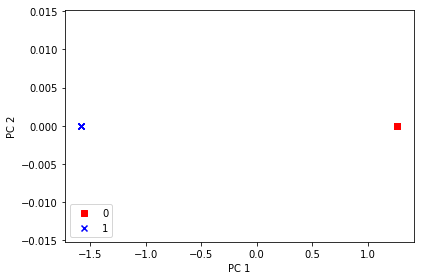

In [251]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0], 
                X_train_pca[y_train == l, 1], 
                c=c, label=l, marker=m)

plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_03.png', dpi=300)
plt.show()

## Principal component analysis in scikit-learn

In [252]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([1.00000000e+00, 1.78041524e-32])

plt.bar(range(0, 343), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(0, 343), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')

plt.show()

In [253]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

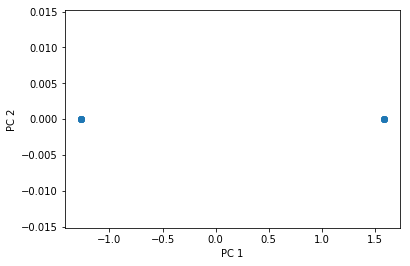

In [254]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.show()

In [255]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=cmap(idx),
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

In [256]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

lr = LogisticRegression()
lr = lr.fit(X_train_pca, y_train)

C:\Users\oishi\Anaconda3\envs\tsa_course\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


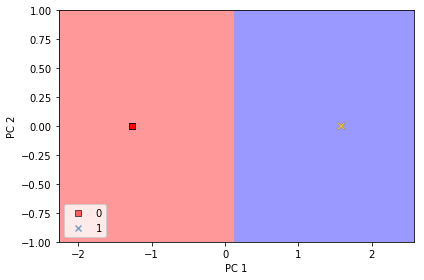

In [257]:
plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

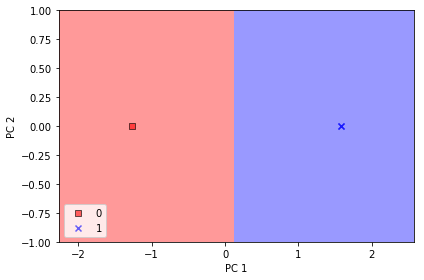

In [258]:
plot_decision_regions(X_test_pca, y_test, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

In [259]:
pca = PCA(n_components=None)
X_train_pca = pca.fit_transform(X_train_std)
pca.explained_variance_ratio_

array([1.00000000e+00, 1.78041524e-32])

from sklearn.ensemble import RandomForestClassifier

feat_labels = features_filtered_df.columns[:]  # Select all 342 feature columns

forest = RandomForestClassifier(n_estimators=100,  # n_estimators is no. of trees in the forrest default is 100
                                random_state=1)

forest.fit(X_train, y_train)
importances = forest.feature_importances_
importances

indices = np.argsort(importances)[::-1]
##indices = np.argsort(importances)
indices

In [260]:
X_train.shape[0]

9

for f in range(X_train.shape[0]):
    print("%2d) %-*s %f" % (f + 1, 80, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
plt.figure(figsize=(11,4))
plt.title('Top two Contributing Features')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center')
plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=360) #rotation = 90 is vertical
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
#plt.savefig('images/04_09.png', dpi=300)
plt.show()

### Feature Scaling the Data before training a Model

There are two types of Feature Scaling methods:

1.Normalisation - rescaled to a range of [0,1].
2. Standardisation - rescaled to a range of [-1,1]

Normalisation is a subset of Standardisation.

Standardisation is recommended as its more usefull for optimization algorithms (gradient descent).

Standardisation centres the feature columns at mean 0 with standard deviation 1 so that the feature columns takes the form of a Normal Distribution, which makes it easier to learn the weights.

Standardisation maintains valuable information about outliers and makes the algorithm less sensitive to them in contrast to min-max scaling (Normalisation), which scales the data to a limited range of values.


Note from Python Machine Learning book chapter 4: Decision trees and Random Forest are two of the very few machine learning algorithms where feature scaling is not neccesary. Those algorithms are scale invariant.

But majority of machine learning and optimization algorithms (eg. Gradient Descent) behave much better if the features are on the same scale.

We fit the StandardScaler class only once - on the training data - and use those parameters to transform the testset or any new data points.

The two essential methods of *Transformer Class* in Scikit-learn are "fit" and "transform".

Fit is used to learn the parameters from the training data.
Transform uses those parameters to transform the data.

*Estimator Class*

#### Feature Scaling is not needed on Tree based model.
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

sc.fit(X_train)

X_train_std = sc.transform(X_train)

X_test_std = sc.transform(X_test)

### Building a Machine Leaning Classifier

##### To do: Develop a Ensemble model which includes other ML classifiers as well

### Random Forest

Each tree in the Random Forest is trained on a different dataset, sampled with replacement from the original data. This results in around ~2/3 of distinct observations in each training set. 

In [261]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

#lr = lr.fit(X_train_pca, y_train)

In [262]:
# RandomForestClassifier() is a class and we create a object "classifier" of this class.
# randon_state is used so that the same forest is reproducible
classifier = RandomForestClassifier(n_estimators = 100, random_state = 0) 
classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

n_estimators=10 means there are total 10 decision trees in the forest, 10 is the default value, different values can be passed.
criterion='gini' is the by default. We can also pass criterionas 'entropy'

In [263]:
# Fit the classifier to training set
classifier = classifier.fit(X_train_pca, y_train)

In [264]:
#pred = classifier.predict(X_test_pca)
#pred

In [265]:
y_test

array([1, 0, 1], dtype=int64)

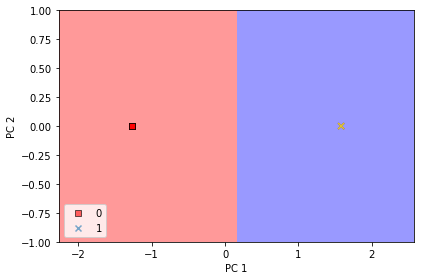

In [266]:
plot_decision_regions(X_train_pca, y_train, classifier=classifier)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_04.png', dpi=300)
plt.show()

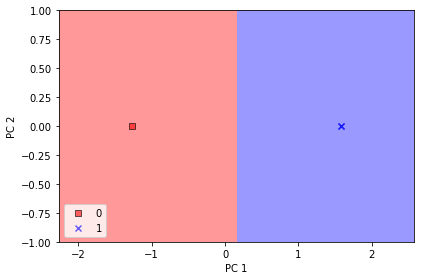

In [267]:
plot_decision_regions(X_test_pca, y_test, classifier=classifier)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.tight_layout()
# plt.savefig('images/05_05.png', dpi=300)
plt.show()

# 4. Model Evaluation

In [268]:
#accuracy_score(y_test, pred)

In [269]:
##Performance of the classifier with 342 extracted features
#print(classification_report(y_test, pred))

### Confusion Metric

cm=confusion_matrix(y_test,pred)
print(cm)
plt.imshow(cm)

### Receiver Operating Characteristics (ROC) Curve

# AOC stands for Area Under the Curve

## To do : need to remove the hard-cording values
actual = [0,1]
predictions = [0,1]

#actual = y_test
#predictions = pred

false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predictions)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = %0.2f'% roc_auc)
plt.plot(figsize=(20,20))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

There are two ways to flatten Numpy arrays:
1. flatten()
flatten is a method of ndarray object, therefore you cant write numpy.flatten().
If the input is 2D or 3D etc, the it returns copy of the array collapsed into 1D array.

ndarray.flatten(order = 'C') C is the default value i.e row wise F is column wise

2. ravel()

ravel is library level function.
It returns contiguous flattened array(1D array with all the input-array elements and with the same type as it). A copy is made only if needed.

np.ravel(array, order = 'C')


# 5. Model Deployment

In [270]:
# Save it as a pickle file
# Documentation - https://docs.python.org/2/library/pickle.html

